# 1. installing dependencies

In [ ]:
# !pip install pycaret

# 2. Load the dataset

In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt


df=pd.read_csv('/content/diabetes_PIMA_preprocessed.csv')
df.shape

(537, 9)

In [ ]:
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,diabetic/non-diabetic
0,6,148,72.0,35.0,0,33.6,0.627,50,1
1,1,85,66.0,29.0,0,26.6,0.351,31,0
2,1,89,66.0,23.0,94,28.1,0.167,21,0
3,0,137,40.0,35.0,168,43.1,2.288,33,1
4,3,78,50.0,32.0,88,31.0,0.248,26,1


# 3. EDA

In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,diabetic/non-diabetic
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,3.510242,119.903166,71.469274,29.186220,113.960894,32.890130,0.501823,31.586592,0.333333
std,3.304281,32.975142,12.302450,10.505807,122.894735,6.875842,0.343643,10.747286,0.471844
min,0.000000,0.000000,24.000000,7.000000,0.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,97.000000,64.000000,22.000000,0.000000,27.800000,0.259000,23.000000,0.000000
50%,2.000000,115.000000,72.000000,29.000000,90.000000,32.800000,0.415000,28.000000,0.000000
75%,5.000000,141.000000,80.000000,36.000000,165.000000,36.900000,0.658000,38.000000,1.000000
max,17.000000,199.000000,110.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
diabetic/non-diabetic       0
dtype: int64

In [ ]:
y=df['diabetic/non-diabetic']
X = df[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']]
percent_pos = sum(y)/len(y)
print('PIMA Percentage Diabetes cases %.02f %%' %(percent_pos * 100))

PIMA Percentage Diabetes cases 33.33 %


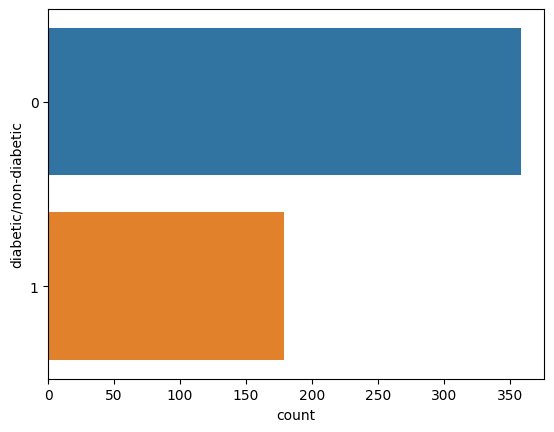

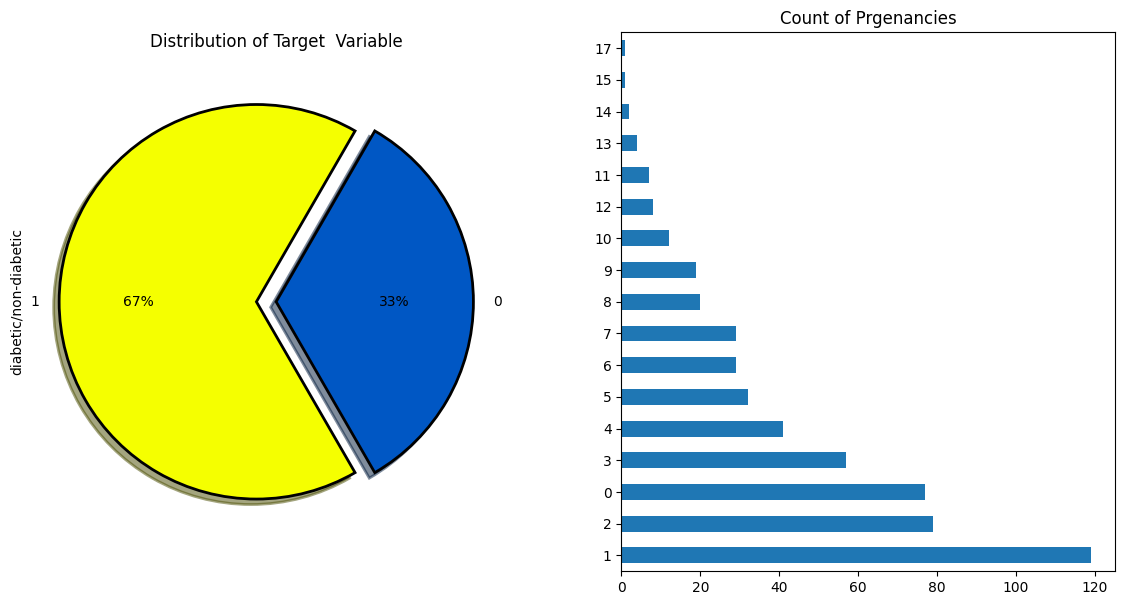

In [ ]:
import seaborn as sns

#Distribution of Target Variable
sns.countplot(y=df['diabetic/non-diabetic'],data=df)

# plotting to create pie chart and bar plot as subplots
plt.figure(figsize=(14,7))
plt.subplot(121)
df["diabetic/non-diabetic"].value_counts().plot.pie(autopct = "%1.0f%%",colors = sns.color_palette("prism",7),startangle = 60,labels=["1","0"],
wedgeprops={"linewidth":2,"edgecolor":"k"},explode=[.1,0],shadow =True)
plt.title("Distribution of Target  Variable")

plt.subplot(122)
ax = df["Pregnancies"].value_counts().plot(kind="barh")

plt.title("Count of Prgenancies")
plt.show()

## As we can see from the distribution, the dataset is almost balanced wrt target class

<Axes: title={'center': 'Correlation with Diabetes'}>

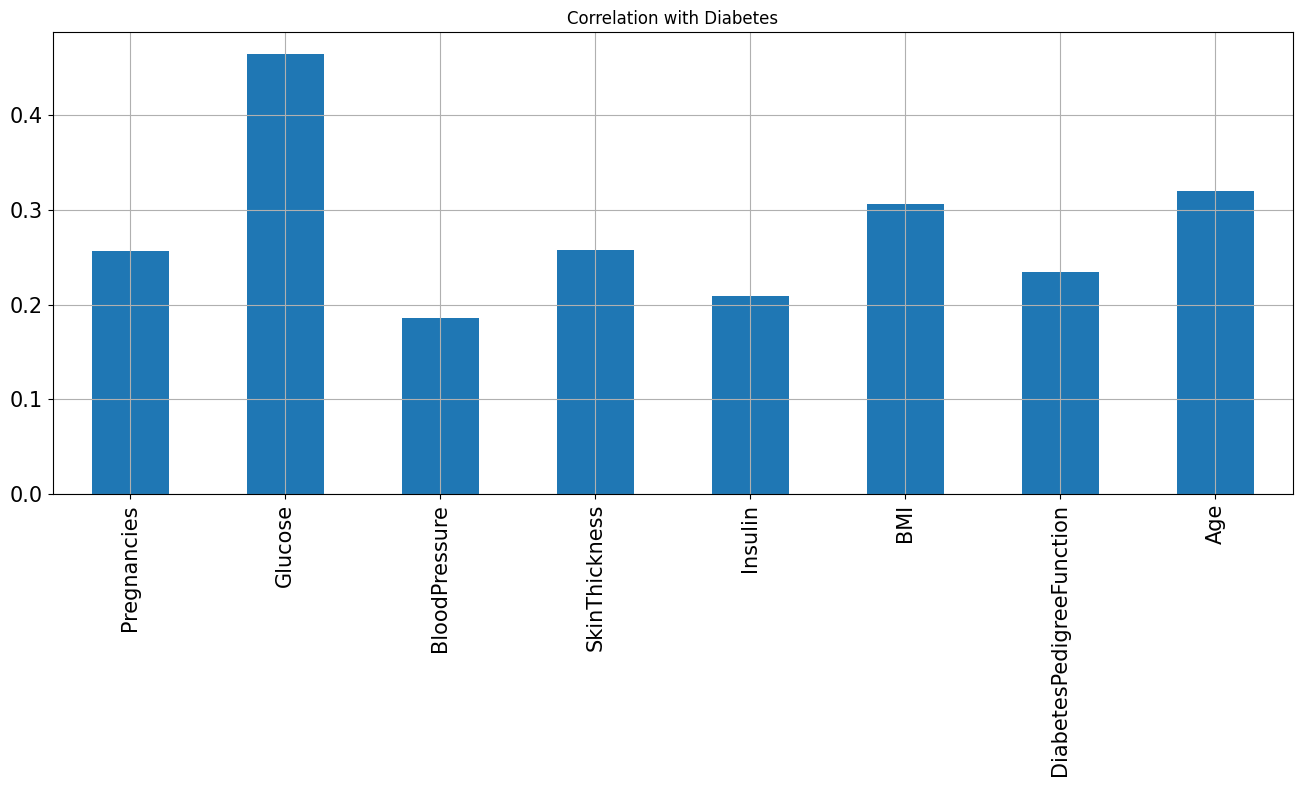

In [ ]:
X.corrwith(y).plot.bar(
        figsize = (16, 6), title = "Correlation with Diabetes", fontsize = 15,
        rot = 90, grid = True)

## Glucose, Age and BMI seem to be highly correlated with the target variable

# 4. Model Training

In [ ]:
from pycaret.classification import *
exp_clf = setup(data = df, target = 'diabetic/non-diabetic', session_id=123) 

,Description,Value
0,Session id,123
1,Target,diabetic/non-diabetic
2,Target type,Binary
3,Original data shape,"(537, 9)"
4,Transformed data shape,"(537, 9)"
5,Transformed train set shape,"(375, 9)"
6,Transformed test set shape,"(162, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


In [ ]:
# compare baseline models
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8056,0.8611,0.6391,0.7697,0.6790,0.5439,0.5627,0.2020
ridge,Ridge Classifier,0.7922,0.0000,0.5981,0.7563,0.6481,0.5063,0.5255,0.0570
lda,Linear Discriminant Analysis,0.7922,0.8738,0.5981,0.7563,0.6481,0.5063,0.5255,0.0590
ada,Ada Boost Classifier,0.7897,0.8422,0.6321,0.7168,0.6565,0.5086,0.5208,0.1470
lr,Logistic Regression,0.7895,0.8717,0.6064,0.7295,0.6512,0.5040,0.5162,0.2690
lightgbm,Light Gradient Boosting Machine,0.7869,0.8726,0.6397,0.7088,0.6586,0.5065,0.5196,0.1490
xgboost,Extreme Gradient Boosting,0.7816,0.8645,0.6474,0.7063,0.6607,0.5020,0.5146,0.1690
rf,Random Forest Classifier,0.7762,0.8551,0.5679,0.7146,0.6136,0.4636,0.4816,0.3980
dt,Decision Tree Classifier,0.7632,0.7347,0.6494,0.6550,0.6484,0.4707,0.4733,0.0430
nb,Naive Bayes,0.7628,0.8504,0.6385,0.6502,0.6342,0.4604,0.4693,0.0410


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

2 models have shown satisfactory results:
1. Gradient Boost Classifier - has high accuracy, F1 Score and precision
2. Decision Tree - has high recall

Since, the cost of false negatives(a person having diabetes but getting predicted as not having diabetes) is high in this case, recall is an important parameter to be considered

## Implementing Gradient Boost Classifier

In [ ]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8421,0.8246,0.6923,0.8182,0.7500,0.6358,0.6405
1,0.8158,0.8338,0.6154,0.8000,0.6957,0.5668,0.5768
2,0.7632,0.9169,0.8462,0.6111,0.7097,0.5183,0.5379
3,0.6579,0.7508,0.5385,0.5000,0.5185,0.2538,0.2542
4,0.8421,0.8677,0.6154,0.8889,0.7273,0.6213,0.6421
5,0.8919,0.9233,0.9167,0.7857,0.8462,0.7636,0.7690
6,0.8108,0.8433,0.5000,0.8571,0.6316,0.5159,0.5498
7,0.8649,0.9300,0.8333,0.7692,0.8000,0.6982,0.6995
8,0.7838,0.8500,0.4167,0.8333,0.5556,0.4330,0.4784


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning the model further

In [ ]:
tuned_gbc = tune_model(gbc, n_iter = 100, optimize = 'recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7105,0.7200,0.5385,0.5833,0.5600,0.3448,0.3454
1,0.8421,0.8738,0.7692,0.7692,0.7692,0.6492,0.6492
2,0.8158,0.9015,0.8462,0.6875,0.7586,0.6122,0.6209
3,0.7105,0.7785,0.6154,0.5714,0.5926,0.3686,0.3692
4,0.8421,0.8923,0.6923,0.8182,0.7500,0.6358,0.6405
5,0.8378,0.9000,0.7500,0.7500,0.7500,0.6300,0.6300
6,0.7568,0.8100,0.5833,0.6364,0.6087,0.4327,0.4336
7,0.9189,0.9300,0.9167,0.8462,0.8800,0.8189,0.8204
8,0.7568,0.8067,0.5833,0.6364,0.6087,0.4327,0.4336


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


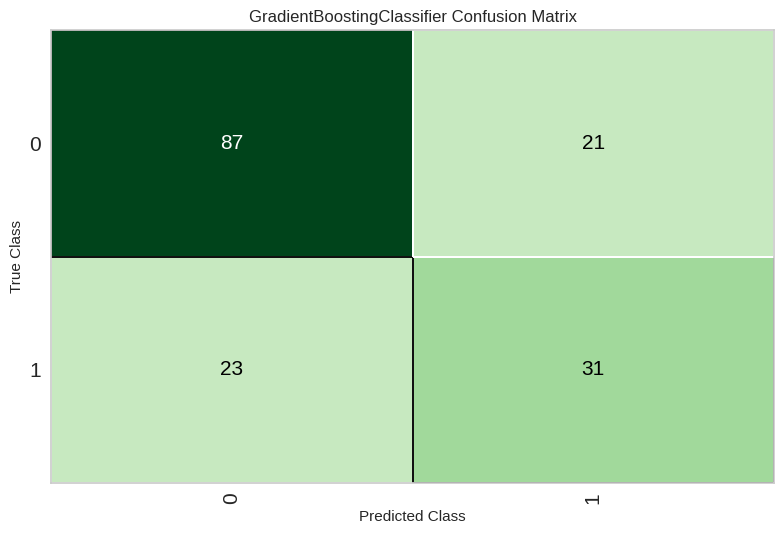

In [ ]:
# plot confusion matrix
plot_model(tuned_gbc, plot = 'confusion_matrix')

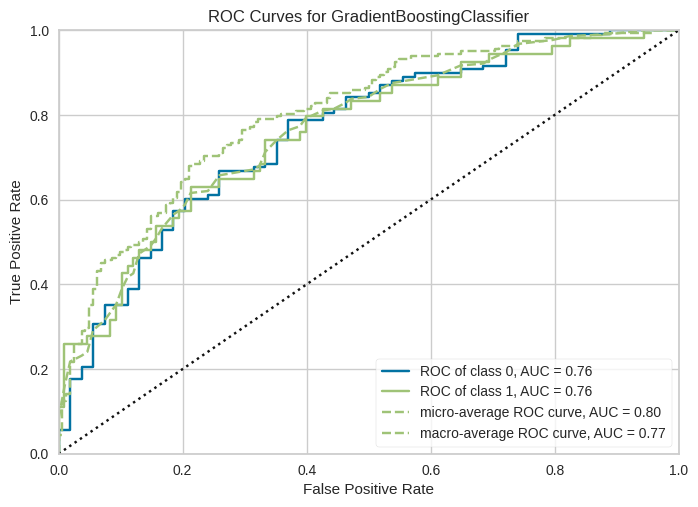

In [ ]:
# plot AUC
plot_model(tuned_gbc, plot = 'auc')

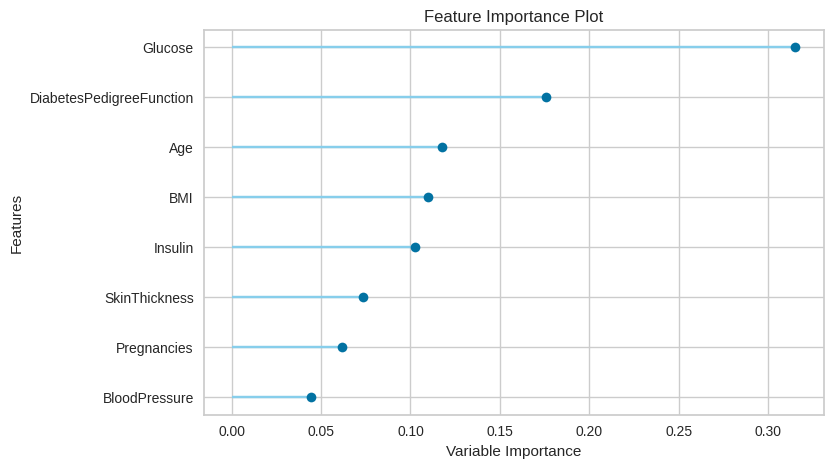

In [ ]:
plot_model(tuned_gbc, plot='feature')

## As observed from correlation plot, Glucose levels seem to be the most important parameter

## Implementing Decision Tree classifier

In [ ]:
dt = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8684,0.8446,0.7692,0.8333,0.8000,0.7022,0.7034
1,0.7632,0.7092,0.5385,0.7000,0.6087,0.4430,0.4508
2,0.6842,0.6677,0.6154,0.5333,0.5714,0.3234,0.3255
3,0.6053,0.6077,0.6154,0.4444,0.5161,0.1972,0.2046
4,0.7105,0.6692,0.5385,0.5833,0.5600,0.3448,0.3454
5,0.8649,0.8567,0.8333,0.7692,0.8000,0.6982,0.6995
6,0.8108,0.7950,0.7500,0.6923,0.7200,0.5775,0.5785
7,0.7838,0.7533,0.6667,0.6667,0.6667,0.5067,0.5067
8,0.7297,0.6700,0.5000,0.6000,0.5455,0.3554,0.3584


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tuned_dt = tune_model(dt, n_iter = 100, optimize = 'recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7895,0.7908,0.6923,0.6923,0.6923,0.5323,0.5323
1,0.7895,0.7877,0.6923,0.6923,0.6923,0.5323,0.5323
2,0.7368,0.8585,0.6923,0.6000,0.6429,0.4362,0.4390
3,0.6842,0.6769,0.6154,0.5333,0.5714,0.3234,0.3255
4,0.7632,0.8262,0.6923,0.6429,0.6667,0.4834,0.4842
5,0.8108,0.8867,0.9167,0.6471,0.7586,0.6105,0.6356
6,0.7838,0.8000,0.5833,0.7000,0.6364,0.4843,0.4884
7,0.7838,0.8100,0.6667,0.6667,0.6667,0.5067,0.5067
8,0.7297,0.7383,0.5833,0.5833,0.5833,0.3833,0.3833


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


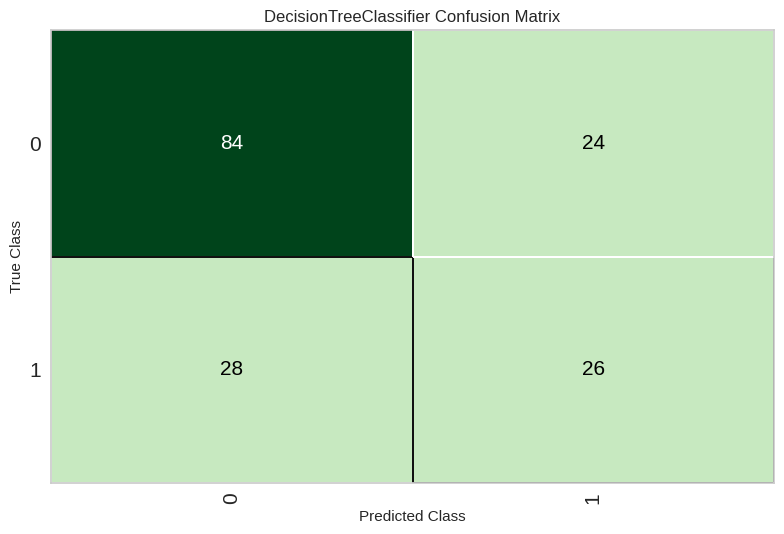

In [ ]:
# plot confusion matrix
plot_model(tuned_dt, plot = 'confusion_matrix')

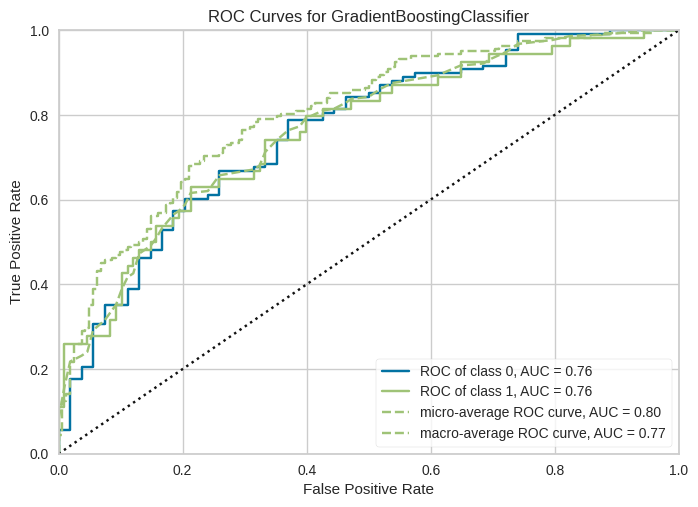

In [ ]:
# plot AUC
plot_model(tuned_gbc, plot = 'auc')

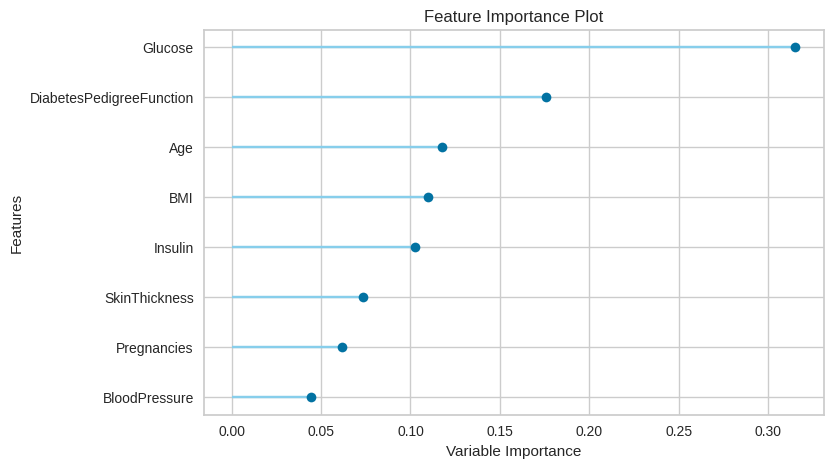

In [ ]:
plot_model(tuned_gbc, plot='feature')

## Tuned Gradient Boost Classifier now shows an overall better performance compared to Decision Tree

# 5. Implementing a custom-built hypertuned Gradient Boost Classifier 

In [ ]:
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve,f1_score, precision_score, recall_score,auc,roc_curve
from sklearn.model_selection import StratifiedShuffleSplit


from sklearn.preprocessing import  LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

In [ ]:
def pima_data_prep(df = None, do_balance = False):
    X = df.drop(["diabetic/non-diabetic"], axis = 1)
    y = df["diabetic/non-diabetic"]
        
    if do_balance:
        # transform the dataset
        oversample = SMOTE(random_state=123)
        X, y = oversample.fit_resample(X, y)        
    
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.30, 
                                                    random_state = 123)

    return X, y ,X_train, X_test, y_train, y_test

In [ ]:
# Utility function to train and evaluate a model on PIMA dataset
def train_and_evaluate_model(model,X,y, verbose=False, n_splits=10):
    acc = 0
    auc = 0
    f1 = 0
    prec = 0
    recall = 0
    
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.3, random_state=123)
    
    start_time = time.time()
    for train_index, test_index in sss.split(X, y):
        if X is pd.DataFrame:
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        else:
            X_train, X_test = X[train_index], X[test_index]
          
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        acc1 = accuracy_score(y_test, y_pred)
        auc1 = roc_auc_score(y_test, y_pred, average="macro")
        f11 = f1_score(y_test, y_pred, average="macro")
        prec1 = precision_score(y_test, y_pred, average="macro")
        recall1 = recall_score(y_test, y_pred, average="macro")
        if verbose:
            print('acc', acc1)
            print('f1', f11)
            print('recall1', recall1)
            print('auc1', auc1)
        acc += acc1
        auc += auc1
        f1 += f11
        prec += prec1
        recall += recall1
        
    spent_time = time.time() - start_time
    print("Acc      F-Meas   Precis   Recall   AUC      Time")
    print("%.04f\t%.04f\t%.04f\t%.04f\t%.04f\t%0.4f" % (acc/n_splits, f1/n_splits, prec/n_splits, 
                                            recall/n_splits, auc/n_splits, spent_time))

In [ ]:
clf = GradientBoostingClassifier()

In [ ]:
# Prepare dataset with No feature Selection No balancing
X,y, X_train, X_test, y_train, y_test = pima_data_prep(df, do_balance=False)

In [ ]:
#  Train and evaluate the Gradient Boosting Classifier Model
train_and_evaluate_model(clf, X, y, verbose=False)

Acc      F-Meas   Precis   Recall   AUC      Time
0.7660	0.7288	0.7426	0.7236	0.7236	1.0996


In [ ]:
gbc = GradientBoostingClassifier()
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(gbc,parameters,cv=5)
cv.fit(X_train,y_train.values.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='log_loss', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  random_state=None,
                                                  subsample=1.0, tol=0.0001,
                                                  validation_fraction=0.1,
                                                  verbose=0, warm_start=False),
             n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.1, 1, 10, 100],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [5, 50, 250, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [ ]:
display(cv)

Best parameters are: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 250}


0.672 + or -0.007 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 5}
0.715 + or -0.05 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}
0.776 + or -0.042 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 250}
0.765 + or -0.04 for the {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500}
0.672 + or -0.007 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5}
0.747 + or -0.029 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.768 + or -0.047 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
0.757 + or -0.049 for the {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
0.672 + or -0.007 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 5}
0.747 + or -0.029 for the {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.736 + or -0.027 for the {'learning_rate': 0.01, 'max_de

In [ ]:
tuned_clf = GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.01,
                                                  loss='log_loss', max_depth=1,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=250,
                                                  n_iter_no_change=None,
                                                  random_state=None,
                                                  subsample=1.0, tol=0.0001,
                                                  validation_fraction=0.1,
                                                  verbose=0, warm_start=False)

In [ ]:
tuned_clf.fit(X_train, y_train)
y_pred = tuned_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
prec = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
print("acc = ",acc)
print("auc = ",auc)
print("f1 = ",f1)
print("precision = ",prec)
print("recall = ",recall)

acc =  0.7530864197530864
auc =  0.6681266846361186
f1 =  0.6785714285714285
precision =  0.7659914712153518
recall =  0.6681266846361186


In [ ]:
train_and_evaluate_model(tuned_clf, X, y, verbose=False)

Acc      F-Meas   Precis   Recall   AUC      Time
0.7636	0.6975	0.7572	0.6847	0.6847	2.9380


In [ ]:
train_and_evaluate_model(tuned_gbc, X, y, verbose=False)

Acc      F-Meas   Precis   Recall   AUC      Time
0.7438	0.7062	0.7141	0.7028	0.7028	0.6393


In [ ]:
train_and_evaluate_model(tuned_dt, X, y, verbose=False)

Acc      F-Meas   Precis   Recall   AUC      Time
0.7160	0.6723	0.6791	0.6699	0.6699	0.1213


# Thus, the custom-built hypertuned Gradient Boost Classifier works the best

In [ ]:
# Do prediction (example) with the trained model
y_pred = tuned_clf.predict(X_test)


In [ ]:
# if We have the labels with can also evaluate the prediction        
acc1 = accuracy_score(y_test, y_pred)
auc1 = roc_auc_score(y_test, y_pred, average="macro")
f11 = f1_score(y_test, y_pred, average="macro")
prec1 = precision_score(y_test, y_pred, average="macro")
recall1 = recall_score(y_test, y_pred, average="macro")
print ('acc', acc1)
print('f1', f11)
print('recall1', recall1)
print('auc1', auc1)


acc 0.7839506172839507
f1 0.7208958897366479
recall1 0.7043463611859838
auc1 0.7043463611859838
